In [3]:
# source("../wwa_model-fitting.R")
source("model-fitting_multi-covariate.R")   # tailored functions for multiple covariates - need to reconcile these somehow

In [2]:
panel.cor <- function(x, y, digits=2, prefix="", cex.cor, ...)
{
    usr <- par("usr")
    par(usr = c(0, 1, 0, 1))
    r <- abs(cor(x, y))
    txt <- format(c(r, 0.123456789), digits=digits)[1]
    txt <- paste(prefix, txt, sep="")
    
    text(0.5, 0.5, txt, cex = 1.2)
    par("usr" = usr)
}

---
---
# **Experiments in modelling heavy OND precipitation**

---
## **Fitted model including ENSO**

In [18]:
cov_lag <- "SON"

gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
iod <- load_ts(paste0("ts/iod_", toupper(cov_lag), ".dat"), col.names = c("year", "iod"))
nino <- load_ts(paste0("ts/nino3.4-detrended_", toupper(cov_lag), ".dat"), col.names = c("year", "nino34"))

gmst_2023 <- gmst$gmst[gmst$year == 2023]
iod_2023 <- iod$iod[iod$year == 2023]

In [22]:
# hangs if run within sapply loop so will set datasets & variables separately
dataset <- "mswep"; varnm <- "rx30day"
             
ts <- merge(load_ts(paste0("ts/HoA-flooding_", dataset, "_OND_rx3day.dat"), col.names = c("year", "rx3day")),
            load_ts(paste0("ts/HoA-flooding_", dataset, "_OND_rx30day_mean.dat"), col.names = c("year", "rx30day")))

df <- merge(merge(merge(gmst, iod), nino), ts)

mdl_fd <- fit_ns("gev", "fixeddisp", df, varnm, c("gmst", "iod", "nino34"))
res <- boot_ci(mdl_fd)

write.csv(res, paste0("res/res-obs_gmst-iod-enso_", varnm, "_", dataset, "_", cov_lag, ".csv"))

In [23]:
nino_2023 <- df$nino34[df$year == 2023]
nino_clim <- mean(df$nino34)
gmst_clim <- mean(df$gmst)
iod_clim <- mean(df$iod)

yl <- c(0,12)

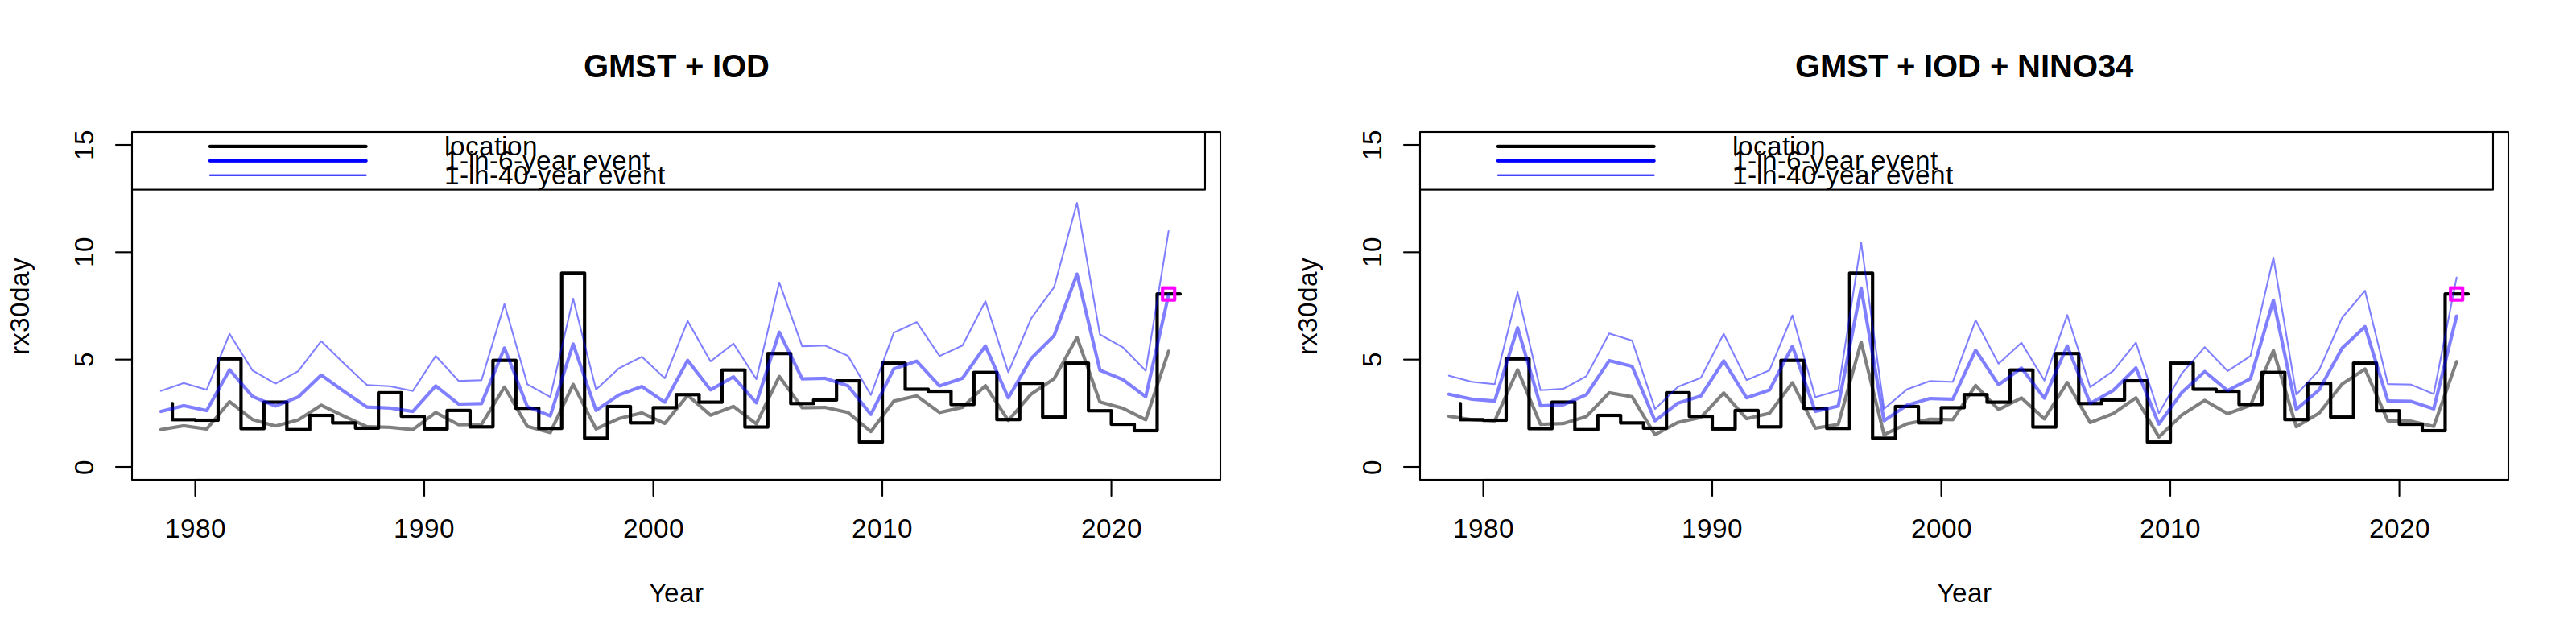

In [26]:
mdl_nino <- fit_ns("gev", "fixeddisp", df, varnm, c("gmst", "iod", "nino34"))
mdl_iod <- fit_ns("gev", "fixeddisp", df, varnm, c("gmst", "iod"))

prep_window(c(1,4)); par(mfrow = c(1,2))

plot_trend(mdl_iod, main = "GMST + IOD", xlim = c(1979, 2023), ylim = c(0,15))
plot_trend(mdl_nino, main = "GMST + IOD + NINO34", xlim = c(1979, 2023), ylim = c(0,15))

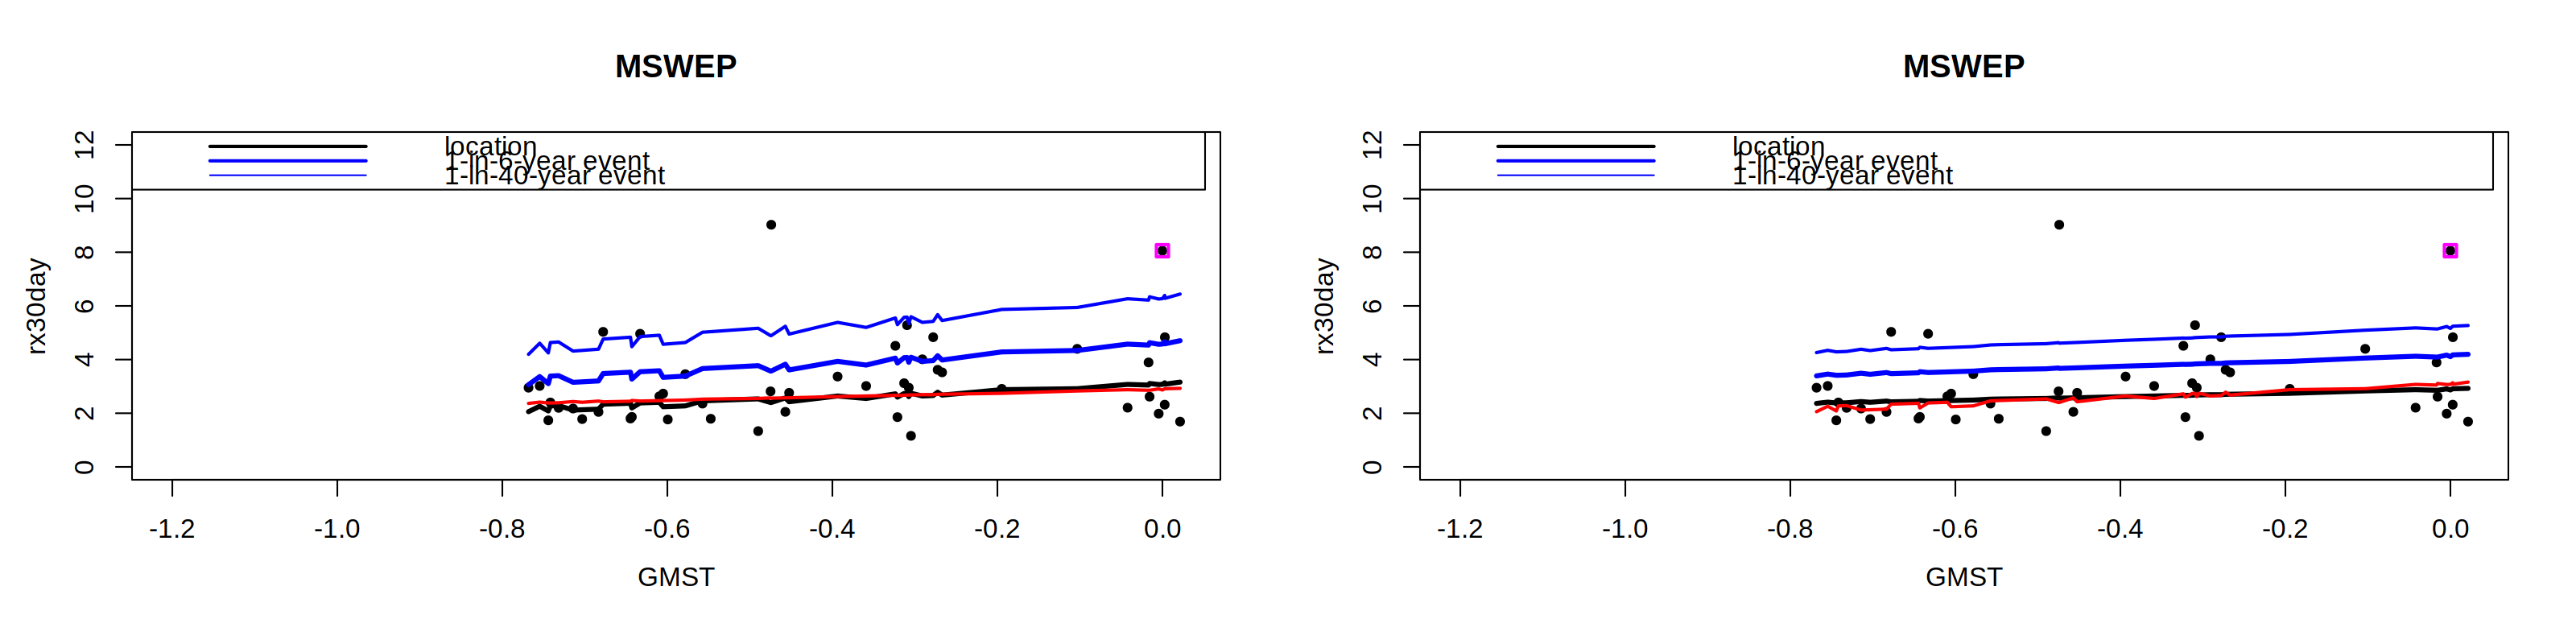

In [27]:
prep_window(c(1,4)); par(mfrow = c(1,2))

plot_covtrend(mdl_iod, xcov = "gmst", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
              cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023), 
              fixed_cov = cbind(df[,c("gmst")], iod_clim))
lines(df$gmst[order(df$gmst)], ns_pars(mdl_nino, fixed_cov = cbind(df[,c("gmst")], iod_clim, nino_clim))$loc[order(df$gmst)], col = "red", lwd = 2)

plot_covtrend(mdl_nino, xcov = "gmst", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023), 
              cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023, "nino34" = nino_2023), 
              fixed_cov = cbind(df[,c("gmst")], iod_clim, nino_clim))
lines(df$gmst[order(df$gmst)], ns_pars(mdl_iod, fixed_cov = cbind(df[,c("gmst")], iod_clim))$loc[order(df$gmst)], col = "red", lwd = 2)

In [28]:
int_change(mdl_iod, rp = 10, cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023),
           cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023), relative = T)

int_change(mdl_nino, rp = 10, cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023),
           cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023, "nino34" = nino_2023), relative = T)

[1] 87.31152

[1] 38.10437

In [29]:
# quick AIC check
2*4 + 2*mdl_iod$value
2*5 + 2*mdl_nino$value

[1] 122.3166

[1] 119.4003

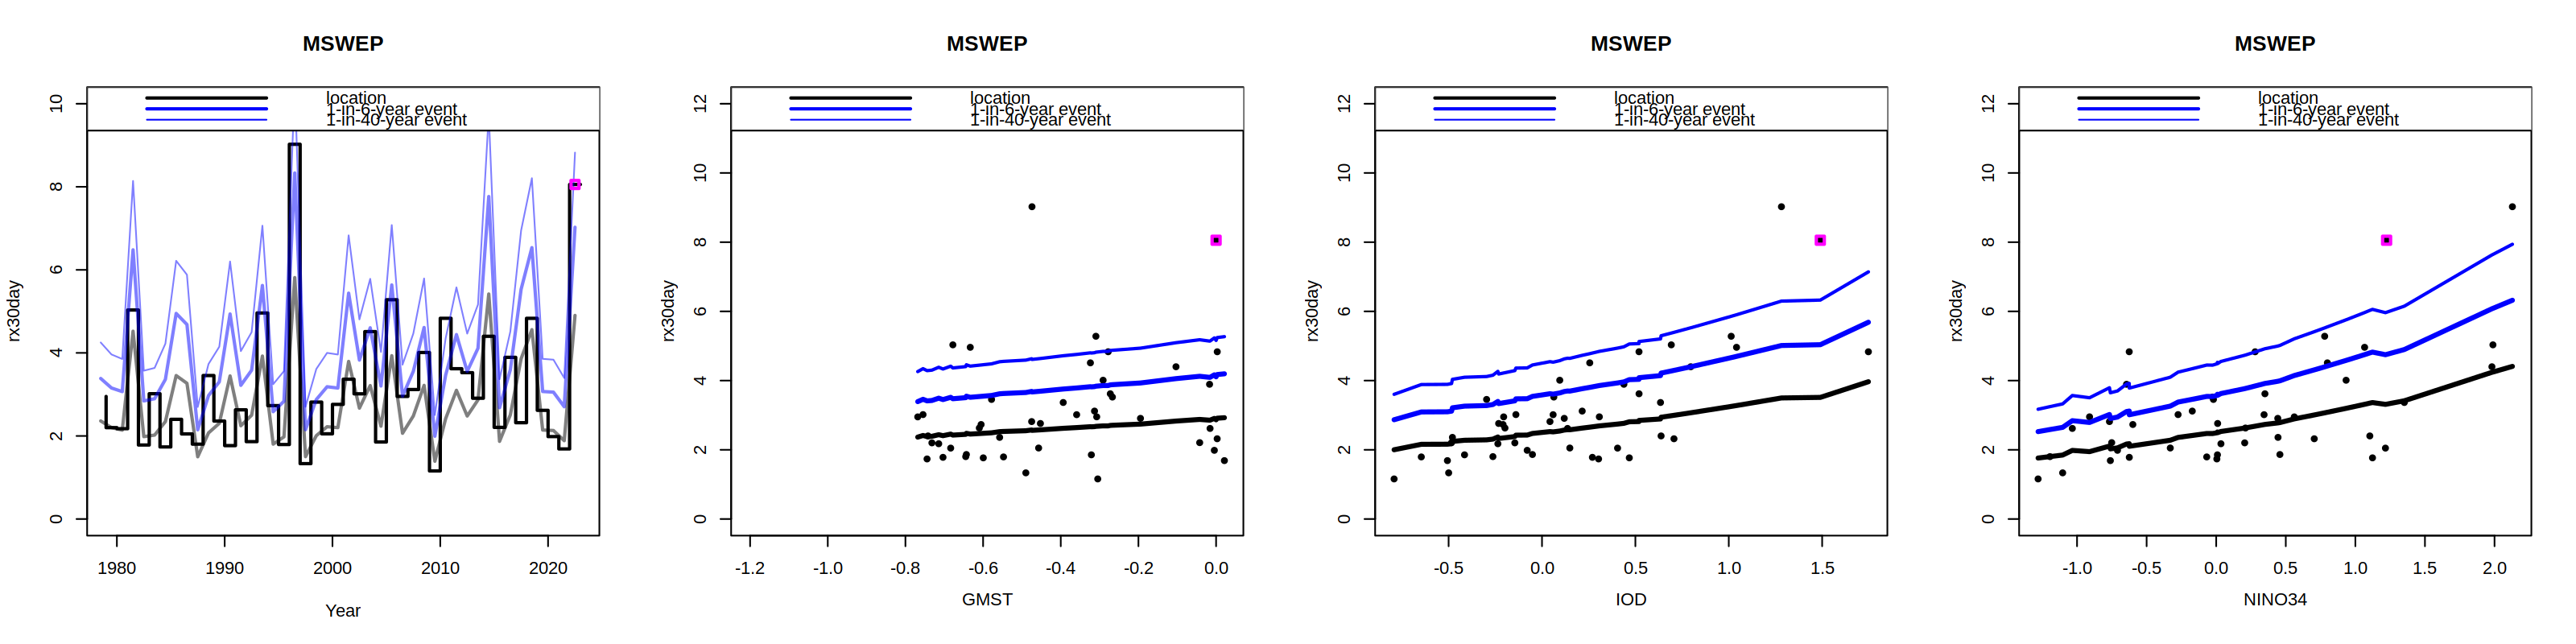

In [30]:
prep_window(c(1,4))

plot_trend(mdl_nino, main = "MSWEP", xlim = c(1979, 2023))

plot_covtrend(mdl_nino, xcov = "gmst", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023), 
              cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023, "nino34" = nino_2023), 
              fixed_cov = cbind(df[,c("gmst")], iod_clim, nino_clim))

plot_covtrend(mdl_nino, xcov = "iod", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023), 
              cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0, "nino34" = nino_2023), 
              fixed_cov = cbind(gmst_clim, df[,c("iod")], nino_clim))

plot_covtrend(mdl_nino, xcov = "nino34", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023), 
              cov_cf = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = 0), 
              fixed_cov = cbind(gmst_clim, iod_clim, df[,c("nino34")]))

In [33]:
int_change(mdl_nino, rp = 10,  relative = T,
           cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023),
           cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023, "nino34" = nino_2023))

int_change(mdl_nino, rp = 10,  relative = T,
           cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023),
           cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0, "nino34" = nino_2023))

int_change(mdl_nino, rp = 10,  relative = T,
           cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023),
           cov_cf = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = 0))

[1] 38.10437

[1] 49.39995

[1] 32.23372

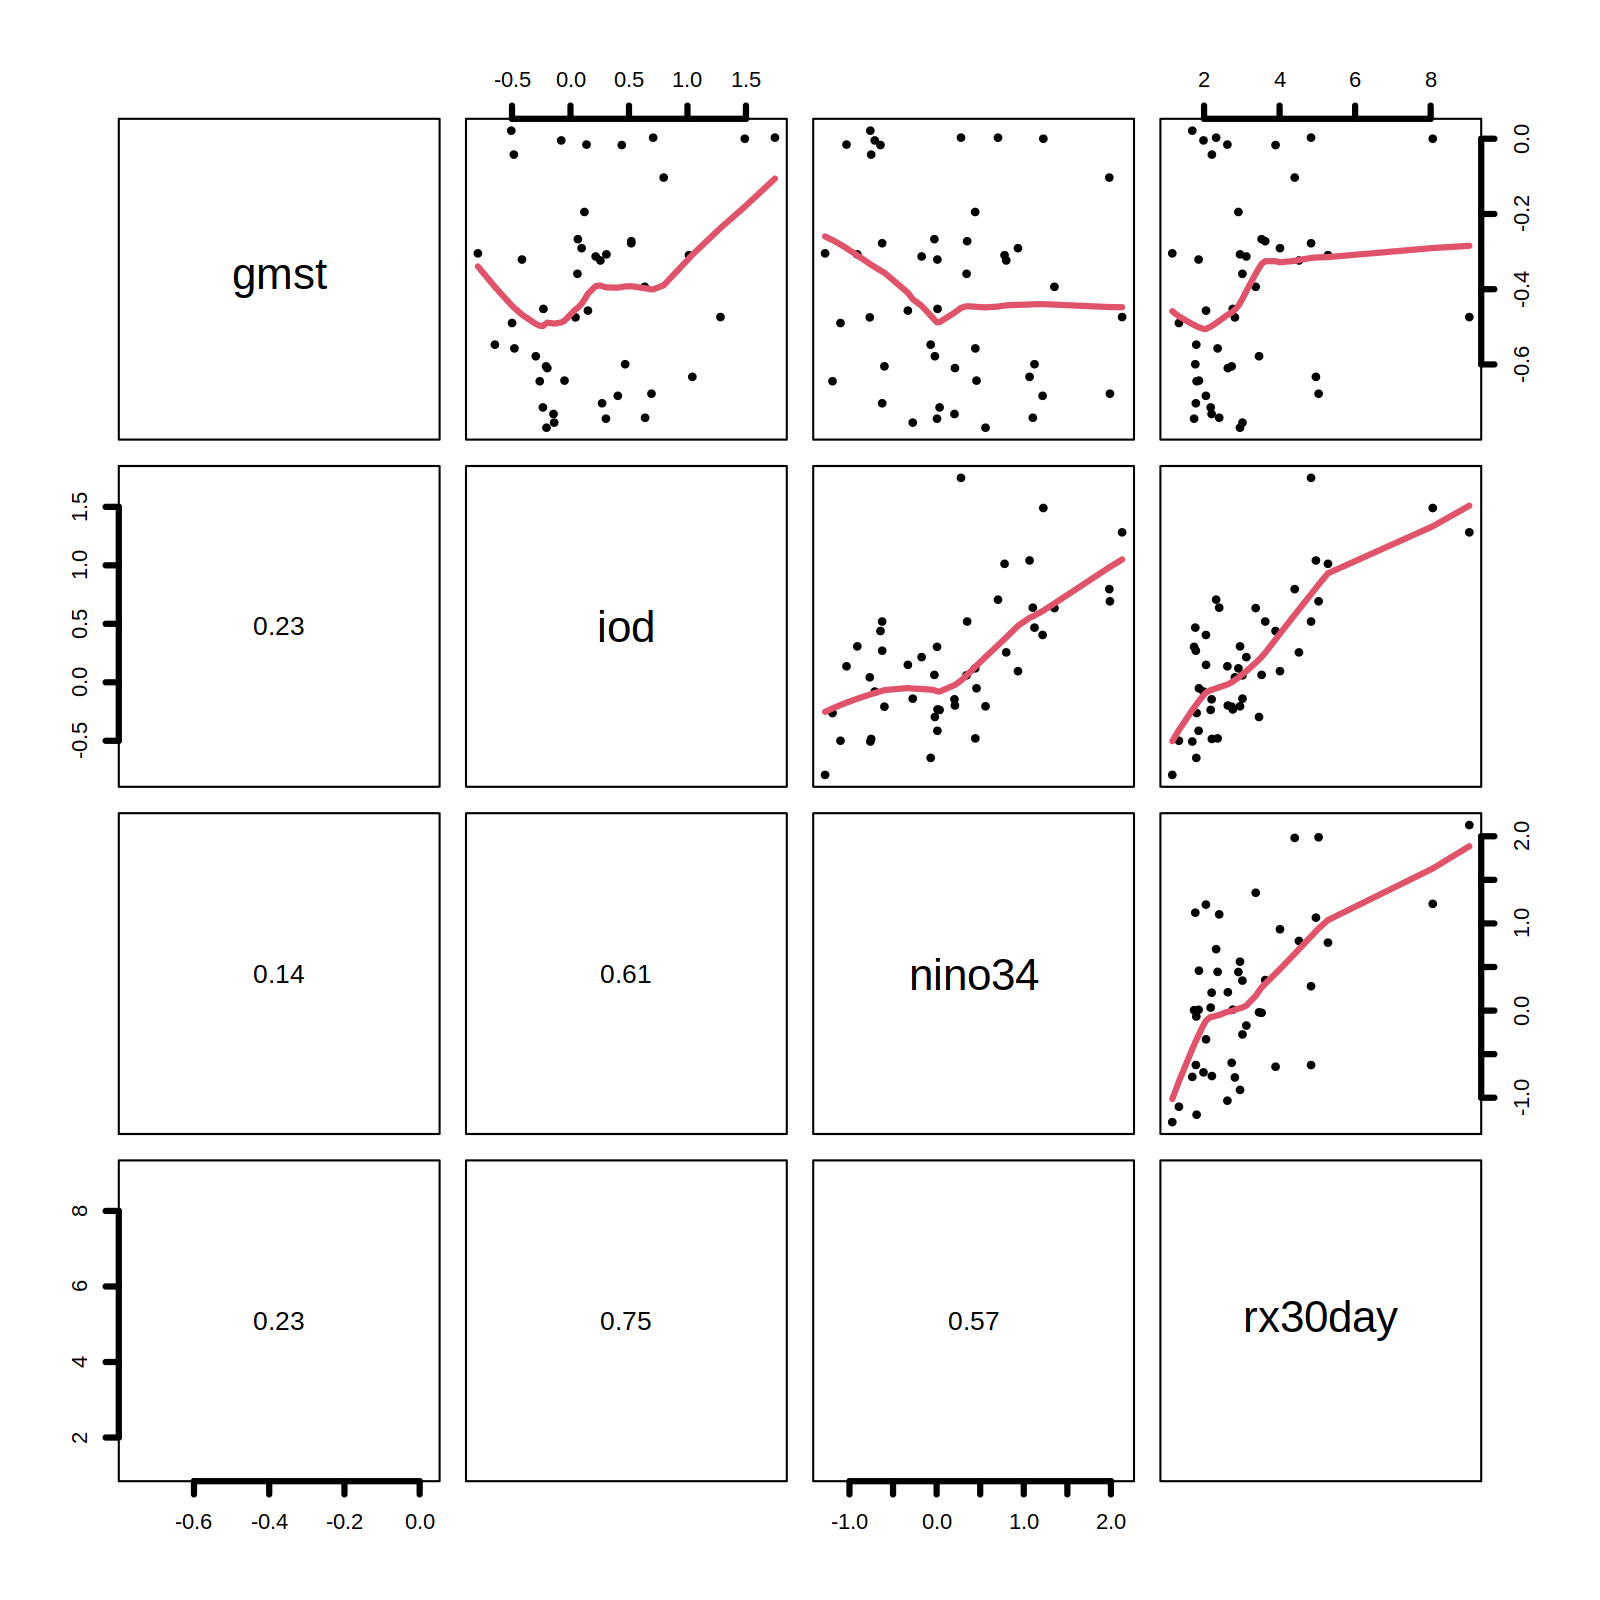

In [43]:
prep_window(c(2,2))
pairs(df[,-c(1,5)], upper.panel = panel.smooth, lower.panel = panel.cor, lwd = 3, pch = 20)

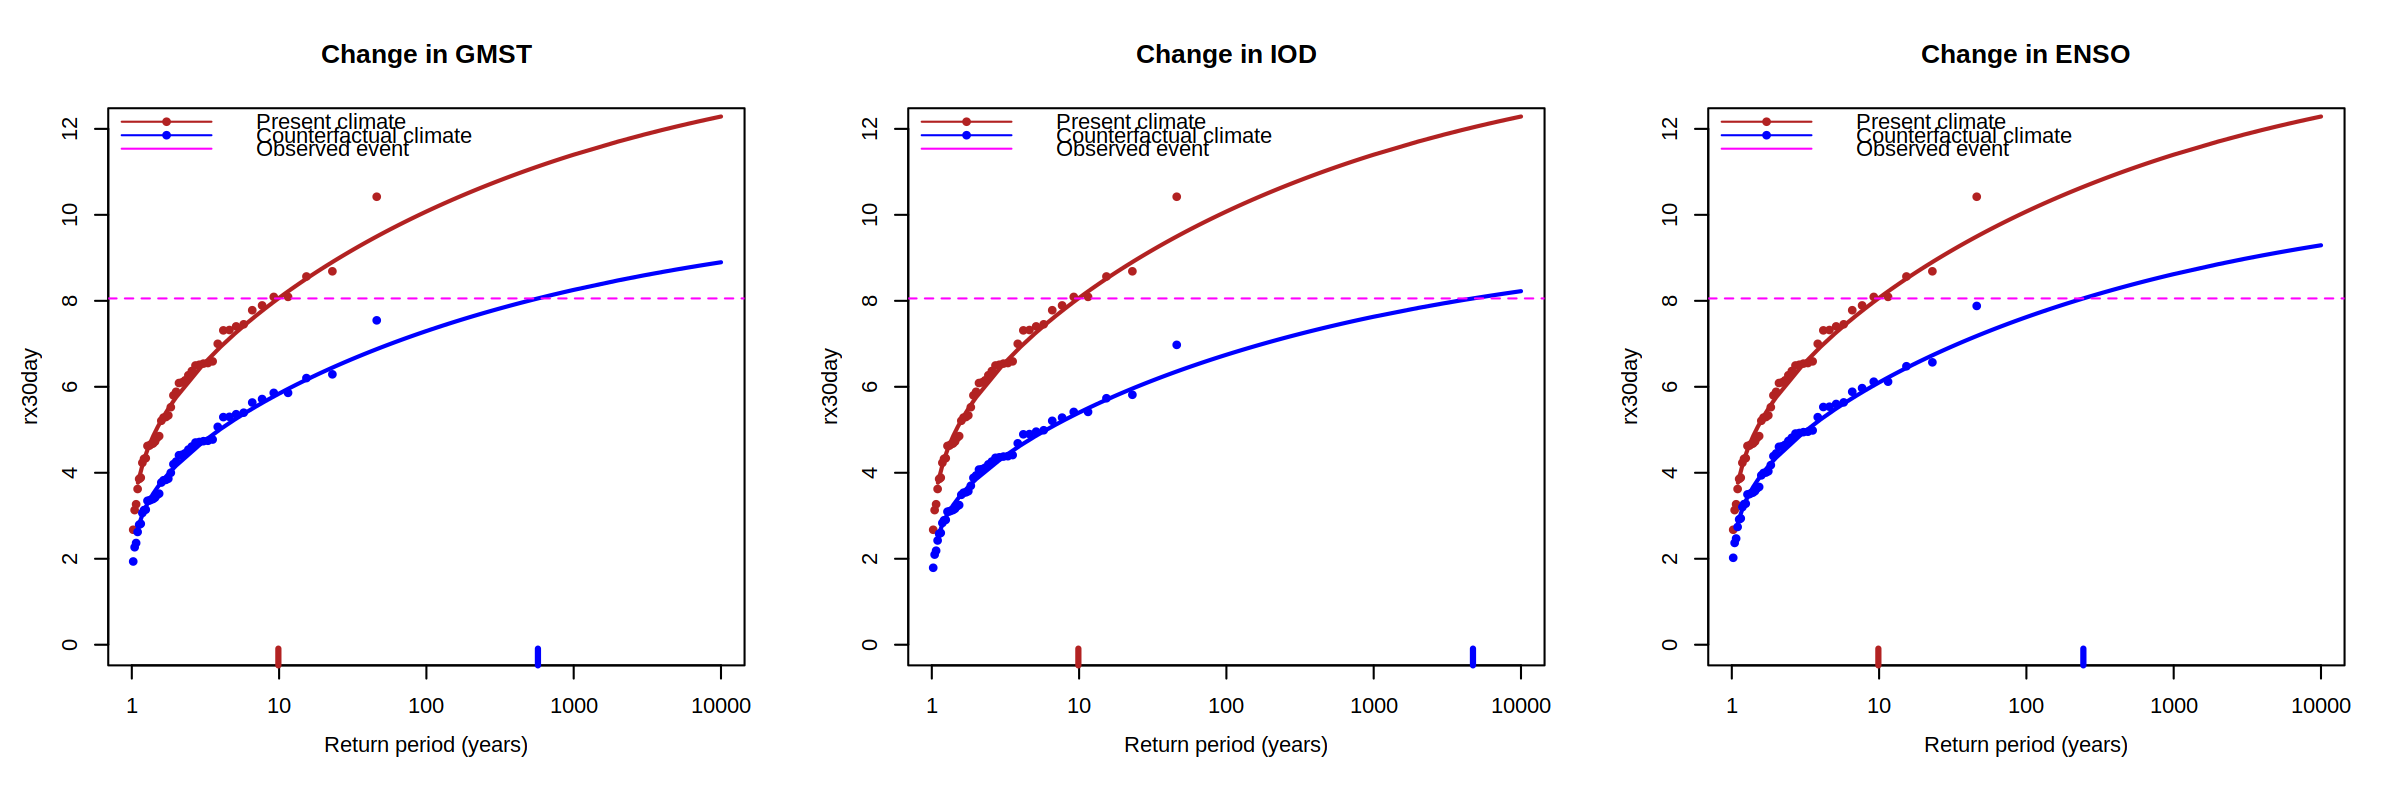

In [51]:
prep_window(c(1,3))

plot_returnlevels(mdl_nino, main = "Change in GMST", ylim = yl, legend_pos = "topleft", nsamp = 50,
                  cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023),
                  cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023, "nino34" = nino_2023))
# points(1/seq(1,0,length.out = nrow(df_mswep)+2)[2:(nrow(df_mswep)+1)], sort(df_mswep$rx3day), pch = 20, col = adjustcolor("black", 0.5))
plot_returnlevels(mdl_nino, main = "Change in IOD", ylim = yl, legend_pos = "topleft", nsamp = 50,
                  cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023),
                  cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0, "nino34" = nino_2023))
# points(1/seq(1,0,length.out = nrow(df_tamsat)+2)[2:(nrow(df_tamsat)+1)], sort(df_tamsat$rx3day), pch = 20, col = adjustcolor("black", 0.5))
plot_returnlevels(mdl_nino, main = "Change in ENSO", ylim = yl, legend_pos = "topleft", nsamp = 50,
                  cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023),
                  cov_cf = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = 0))

## **Experiments**

In [10]:
library(extRemes)
source("../../wwa-archive/methods_extRemes.r")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# tailored functions

aic <- function(mdl) { 2 * length(mdl$parnames) + mdl$results$value * 2 }

rlplot <- function(mdl, qcov_f, qcov_cf, ev, ylim = NA, pch = 20, lower = F, ylab = "value", legend_pos = "bottomright", legend = c("Current", "Counterfactual", "Observed event"), main = "") {
    
    rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000))) # return periods at which to calculate values
    rp_th <- 1/seq(1,0,length.out = length(mdl$x)+2)[2:(length(mdl$x)+1)]                                      # theoretical return periods
    
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    
    pars_f <- findpars(mdl, qcov = qcov_f)
    pars_cf <- findpars(mdl, qcov = qcov_cf)
    
    # prep axes
    plot(0,type = "n", xlim = c(1,10000), ylim = ylim, log = "x", xlab = "Return period (years)", ylab = ylab, main = main)
    
    # return period curves
    lines(rp_x, return.level.fevd(mdl, rp_x, qcov = qcov_f, lower = lower), lwd = 2, col = "firebrick")
    lines(rp_x, return.level.fevd(mdl, rp_x, qcov = qcov_cf, lower = lower), lwd = 2, col = "blue")

    points(rp_th, sort(qevd(pevd(trans(mdl), lower = lower), loc = sum(pars_f$location), scale = pars_f$scale, shape = pars_f$shape, lower = lower)), col = "firebrick", pch = 20)
    points(rp_th, sort(qevd(pevd(trans(mdl), lower = lower), loc = sum(pars_cf$location), scale = pars_cf$scale, shape = pars_cf$shape, lower = lower)), col = "blue", pch = 20)

    abline(h = pr_2023, col = "magenta")
    suppressWarnings(rug(1 / pextRemes(mdl, pr_2023, qcov = qcov_f, lower = lower), lwd = 3, col = "firebrick"))
    suppressWarnings(rug(1 / pextRemes(mdl, pr_2023, qcov = qcov_cf, lower = lower), lwd = 3, col = "blue"))

    legend(legend_pos, legend = legend, col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(20,20,NA), bty = "n")
}

In [11]:
dataset <- "mswep"; varnm <- "rx30day"; cov_lag <- "SON"

gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
iod <- load_ts(paste0("ts/iod_", toupper(cov_lag), ".dat"), col.names = c("year", "iod"))
nino <- load_ts(paste0("ts/nino3.4-detrended_", toupper(cov_lag), ".dat"), col.names = c("year", "enso"))

pr <- load_ts(list.files("ts", pattern = paste0(dataset,".+",varnm), full.names = T), col.names = c("year", "pr"))
df <- merge(merge(merge(gmst, iod), nino), pr)

gmst_2023 <- gmst$gmst[gmst$year == 2023]
iod_2023 <- iod$iod[iod$year == 2023]
enso_2023 <- nino$enso[nino$year == 2023]
pr_2023 <- df$pr[df$year == 2023]

### **Include interactions?**

In [12]:
# linear model, 
mdl_noint <- fevd(pr, df, location.fun = ~ gmst + enso + iod)#
mdl_int_enso_iod <- fevd(pr, df, location.fun = ~ gmst + enso * iod)
mdl_int_gmst_enso <- fevd(pr, df, location.fun = ~ gmst * enso + iod)
mdl_int_gmst_iod <- fevd(pr, df, location.fun = ~ gmst * iod + enso)

In [13]:
# best model fit when interaction between IOD and ENSO is included
data.frame("AIC" = round(sapply(list("No interaction" = mdl_noint, "ENSO-IOD" = mdl_int_enso_iod, "GMST-ENSO" = mdl_int_gmst_enso, "GMST-IOD" = mdl_int_gmst_iod), aic), 2))

,AIC
,<dbl>
No interaction,136.73
ENSO-IOD,135.32
GMST-ENSO,138.41
GMST-IOD,137.37


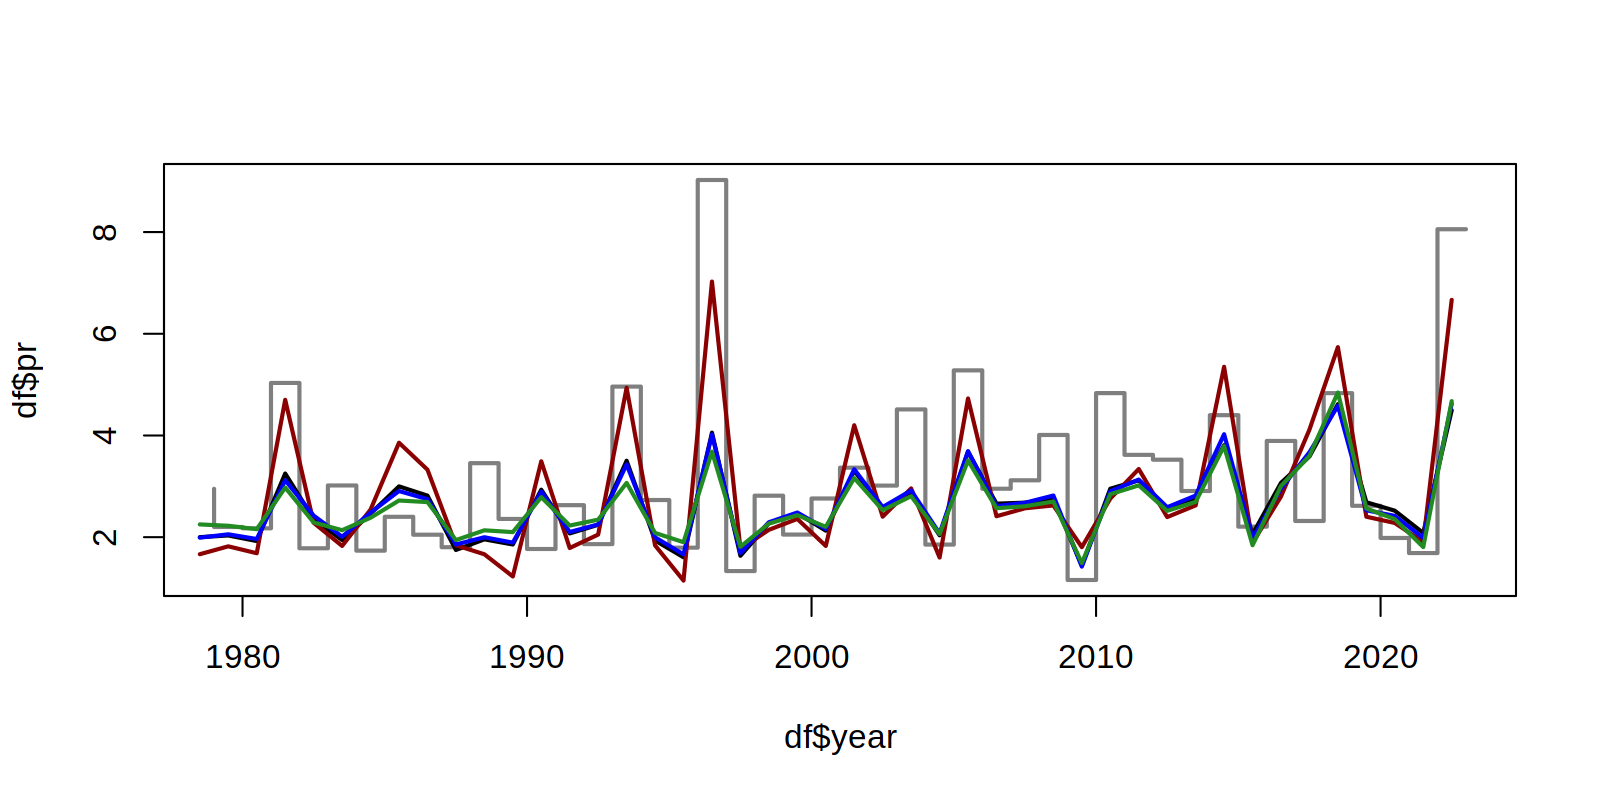

In [15]:
prep_window(c(1,2)); par(mfrow = c(1,1))
plot(df$year, df$pr, type = "S", lwd = 2, col = adjustcolor("black", 0.5))

lines(df$year-0.5, findpars(mdl_noint)$location, col = "black", lwd = 2)
lines(df$year-0.5, findpars(mdl_int_enso_iod)$location, col = "red4", lwd = 2)
lines(df$year-0.5, findpars(mdl_int_gmst_enso)$location, col = "blue", lwd = 2)
lines(df$year-0.5, findpars(mdl_int_gmst_iod)$location, col = "forestgreen", lwd = 2)

# lines(df$year-0.5, findpars(mdl_exp)$location, col = "red4", lwd = 2)

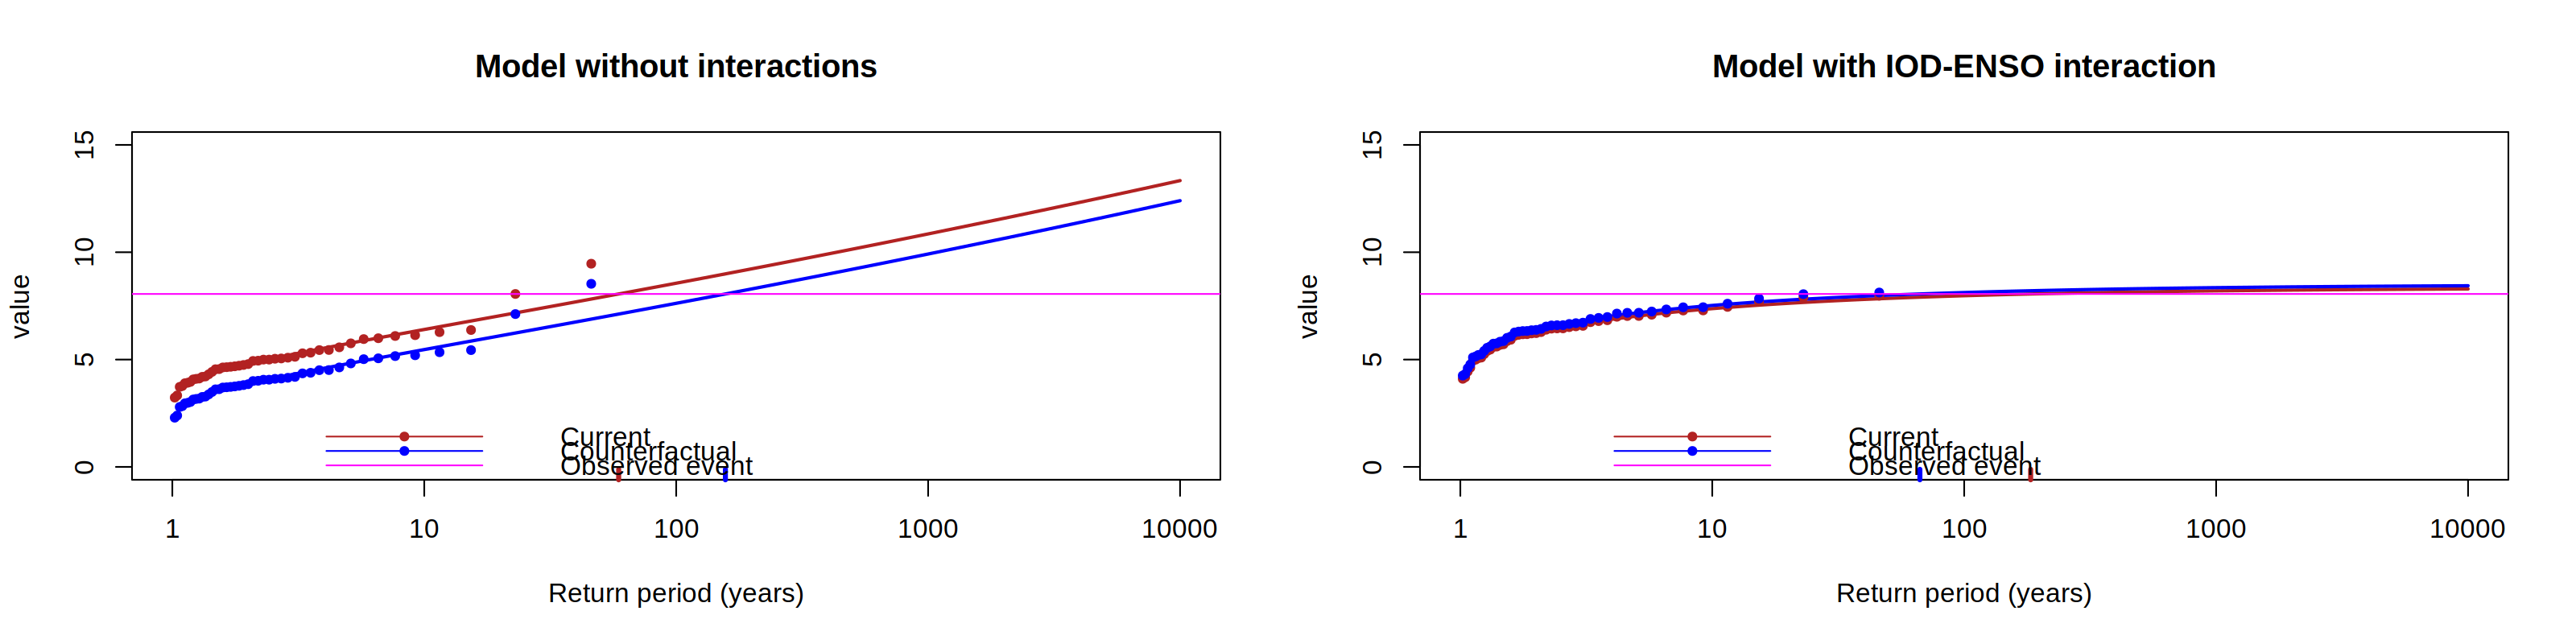

In [24]:
prep_window(c(1,4)); par(mfrow = c(1,2))

rlplot(mdl_noint, 
       qcov_f = make.qcov(mdl_noint, vals = list("mu1" = gmst_2023, "mu2" = enso_2023, "mu3" = iod_2023)),
       qcov_cf = make.qcov(mdl_noint, vals = list("mu1" = gmst_2023-1.2, "mu2" = enso_2023, "mu3" = iod_2023)), ev = pr_2023, ylim = c(0,15),
       main = "Model without interactions")

rlplot(mdl_int_enso_iod, 
       qcov_f = make.qcov(mdl_int_enso_iod, vals = list("mu1" = gmst_2023, "mu2" = enso_2023, "mu3" = iod_2023)), 
       qcov_cf = make.qcov(mdl_int_enso_iod, vals = list("mu1" = gmst_2023-1.2, "mu2" = enso_2023, "mu3" = iod_2023, "mu4" = enso_2023 * iod_2023)), ev = pr_2023, ylim = c(0,15),
       main = "Model with IOD-ENSO interaction")

### **Shift or shift + scale?**

In [25]:
mdl_ss_fullmodel <- fevd(pr, df, location.fun = ~ gmst + enso * iod, scale.fun = ~ gmst + enso * iod, use.phi = T)

mdl_ss_enso_iod_noint <- fevd(pr, df, location.fun = ~ gmst + enso * iod, scale.fun = ~ enso + iod, use.phi = T)
mdl_ss_enso_iod <- fevd(pr, df, location.fun = ~ gmst + enso * iod, scale.fun = ~ enso * iod, use.phi = T)

mdl_ss_enso <- fevd(pr, df, location.fun = ~ gmst + enso * iod, scale.fun = ~ enso, use.phi = T)
mdl_ss_iod <- fevd(pr, df, location.fun = ~ gmst + enso * iod, scale.fun = ~ iod, use.phi = T)


mdl_list <- list("Fixed variance" = mdl_int_enso_iod,
                 "Var ~ enso" = mdl_ss_enso,
                 "Var ~ iod" = mdl_ss_iod,
                 "Var ~ enso + iod" = mdl_ss_enso_iod_noint,
                 "Var ~ enso * iod" = mdl_ss_enso_iod,
                 "Var ~ gmst + enso * iod" = mdl_ss_fullmodel)

data.frame("AIC" = round(sapply(mdl_list, aic), 2))

,AIC
,<dbl>
Fixed variance,135.32
Var ~ enso,122.87
Var ~ iod,114.65
Var ~ enso + iod,114.74
Var ~ enso * iod,116.21
Var ~ gmst + enso * iod,116.75


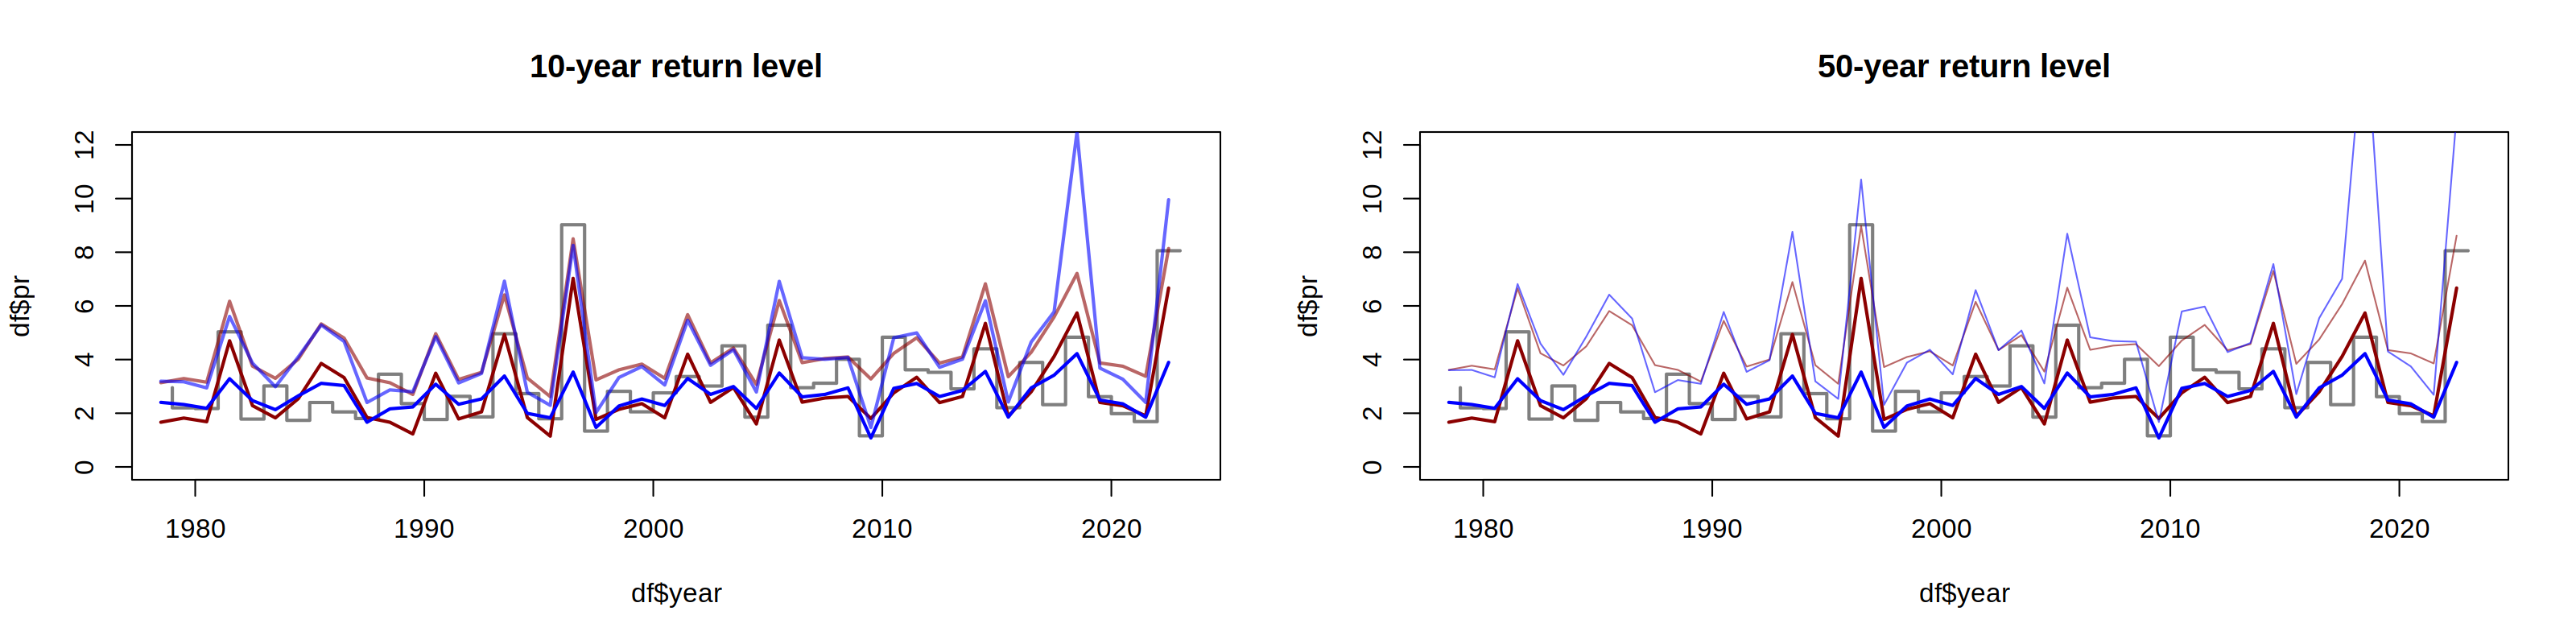

In [26]:
prep_window(c(1,4)); par(mfrow = c(1,2))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year, df$pr, type = "S", lwd = 2, col = adjustcolor("black", 0.5), main = "10-year return level", ylim = c(0,12))
lines(df$year-0.5, findpars(mdl_int_enso_iod)$location, col = "red4", lwd = 2)
lines(df$year-0.5, return.level(mdl_int_enso_iod, 10), col = adjustcolor("red4", 0.6), lwd = 2, lty = 1)

lines(df$year-0.5, findpars(mdl_ss_iod)$location, col = "blue", lwd = 2)
lines(df$year-0.5, return.level(mdl_ss_iod, 10), col = adjustcolor("blue", 0.6), lwd = 2, lty = 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year, df$pr, type = "S", lwd = 2, col = adjustcolor("black", 0.5), main = "50-year return level", ylim = c(0,12))
lines(df$year-0.5, findpars(mdl_int_enso_iod)$location, col = "red4", lwd = 2)
lines(df$year-0.5, return.level(mdl_int_enso_iod, 50), col = adjustcolor("red4", 0.6), lwd = 1, lty = 1)

lines(df$year-0.5, findpars(mdl_ss_iod)$location, col = "blue", lwd = 2)
lines(df$year-0.5, return.level(mdl_ss_iod, 50), col = adjustcolor("blue", 0.6), lwd = 1, lty = 1)

ERROR: Error in if (scale <= 0) stop("qevd: invalid scale argument.  Must be > 0."): the condition has length > 1


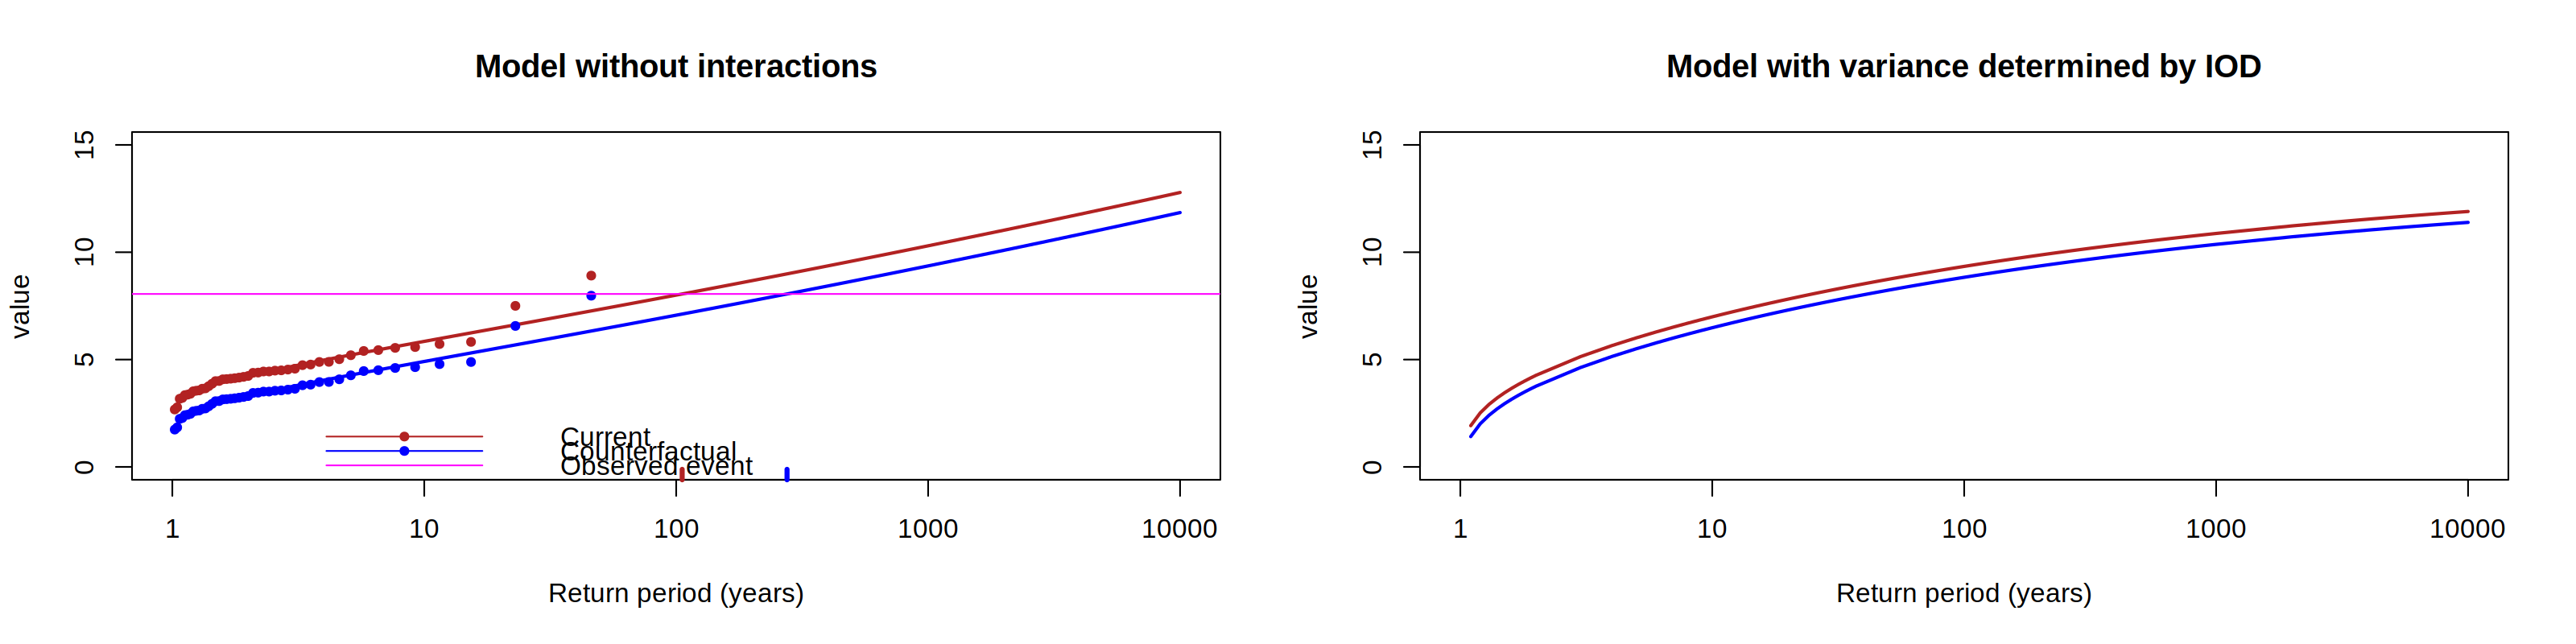

In [28]:
prep_window(c(1,4)); par(mfrow = c(1,2))

rlplot(mdl_noint, 
       qcov_f = make.qcov(mdl_noint, vals = list("mu1" = gmst_2023)),
       qcov_cf = make.qcov(mdl_noint, vals = list("mu1" = gmst_2023-1.2)), ev = pr_2023, ylim = c(0,15),
       main = "Model without interactions")

# unclear how to include interactions in qcov
rlplot(mdl_ss_iod, 
       qcov_f = make.qcov(mdl_ss_iod, vals = list("mu1" = gmst_2023)), 
       qcov_cf = make.qcov(mdl_ss_iod, vals = list("mu1" = gmst_2023-1.2)), ev = pr_2023, ylim = c(0,15),
       main = "Model with variance determined by IOD")

In [229]:
make.qcov(mdl_noint, vals = list("mu1" = gmst_2023))

mu0,mu1,mu2,mu3,scale,shape,threshold
1,0,1,1,1,1,NA


In [227]:
make.qcov(mdl_noint, vals = list("mu1" = gmst_2023, "mu2" = enso_2023, "mu3" = iod_2023))

mu0,mu1,mu2,mu3,scale,shape,threshold
1,0,1.224512,1.490137,1,1,NA


[1] 116.7521

### **Linear or exponential model?**

In [ ]:
mdl_exp <- fevd(pr, df, location.fun = ~ exp(gmst) + exp(enso) * exp(iod))